In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:0')
print(device)

cuda:0


In [3]:
class Hyperparameter():
    def __init__(self):
        self.dict = {}
        self.dict['optimizer'] = {}
        self.dict['optimizer']['lr'] = [1e-4, 5.5e-6]
        self.dict['optimizer']['beta'] = [(0.9, 0.999), (0.9, 0.999)]
        self.dict['optimizer']['eps'] = [1e-7, 1e-7]
        self.dict['optimizer']['method'] = 'Adam'
    
        self.dict['epoch'] = [100, 100]
        self.dict['batch_size'] = 32
        self.dict['patience'] = 20
        self.dict['min_delta'] = 1e-4
        
        self.dict['training_data'] = {}
        self.dict['training_data']['path'] = '/home/chenyu/Desktop/CNNmeasurement/TrainingData_CoarseCNN/'
        self.dict['training_data']['data'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_128pxRonch_x25000.npy'
        self.dict['training_data']['label_1'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_45mradnewEmit_x25000.npy'
        self.dict['training_data']['label_2'] = 'FullRandom_50mrad_2ndOrder_highAbr_whiteNoise_32pxGaussian_multiNoise_30pA_defocus_x25000.npy'
        self.dict['training_data']['split'] = 0.8
        self.dict['training_data']['aperture'] = 45
        self.dict['training_data']['limit'] = 50
        
        self.dict['segmentation'] = {}
        self.dict['segmentation']['resize'] = (135, 135)
        self.dict['segmentation']['ratio'] = (0.97, 1.03)
        self.dict['segmentation']['scale'] = (0.9, 1.0)
        self.dict['segmentation']['normalize'] = None
        
        self.dict['architecture'] = {}
        self.dict['architecture']['dropout'] = 0.5
        self.dict['architecture']['linear_shape'] = [512]
        
        self.process = {}
        
        self.process['training'] = []
        self.process['validation'] = []
        
    def add_training_process(self, training_acc, validation_acc, epoch):
        if epoch == 0:
            self.process['training'].append([])
            self.process['validation'].append([])
        if torch.is_tensor(training_acc):
            training_acc = training_acc.cpu().detach().numpy()
        if torch.is_tensor(validation_acc):
            validation_acc = validation_acc.cpu().detach().numpy()
        self.process['training'][-1].append(training_acc)
        self.process['validation'][-1].append(validation_acc)
        return
    
    def save_result(self, path):
        with open(path + 'hyperparameter.pkl', 'wb') as f:
            pickle.dump(self.dict, f)
        with open(path + 'training_log.pkl', 'wb') as f:
            pickle.dump(self.process, f)

In [4]:
par = Hyperparameter()

In [5]:
# Customized CNN model
class Net(Module):   
    def __init__(self, pretrained = False, dropout = 0.3, linear_shape = 512):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv2 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv5 = nn.Conv2d(128, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv6 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv7 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv8 = nn.Conv2d(256, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv9 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv10 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv11 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv12 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv13 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.fc1 = nn.Linear(4 * 4 * 512, linear_shape)
        self.dropout = nn.Dropout(p = dropout)
#         self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(linear_shape, 1)
    
    def lock_base(self):
        for parameter in self.parameters():
            parameter.requires_grad = False
        self.fc1.weight.requires_grad = True
        self.fc1.bias.requires_grad = True
#         self.fc2.weight.requires_grad = True
#         self.fc2.bias.requires_grad = True
        self.fc3.weight.requires_grad = True
        self.fc3.bias.requires_grad = True
    
    def unlock_base(self):
        for parameter in self.parameters():
            parameter.requires_grad = True
            
    def load_pretrained(self):
        print("Loading weights and bias from VGG16.")
        vgg16 = torchvision.models.vgg16(pretrained = True)
        self.conv1.weight.data = vgg16.features[0].weight.data.to(device = device)
        self.conv1.bias.data = vgg16.features[0].bias.data.to(device = device)
        self.conv2.weight.data = vgg16.features[2].weight.data.to(device = device)
        self.conv2.bias.data = vgg16.features[2].bias.data.to(device = device)
        self.conv3.weight.data = vgg16.features[5].weight.data.to(device = device)
        self.conv3.bias.data = vgg16.features[5].bias.data.to(device = device)
        self.conv4.weight.data = vgg16.features[7].weight.data.to(device = device)
        self.conv4.bias.data = vgg16.features[7].bias.data.to(device = device)
        self.conv5.weight.data = vgg16.features[10].weight.data.to(device = device)
        self.conv5.bias.data = vgg16.features[10].bias.data.to(device = device)
        self.conv6.weight.data = vgg16.features[12].weight.data.to(device = device)
        self.conv6.bias.data = vgg16.features[12].bias.data.to(device = device)
        self.conv7.weight.data = vgg16.features[14].weight.data.to(device = device)
        self.conv7.bias.data = vgg16.features[14].bias.data.to(device = device)
        self.conv8.weight.data = vgg16.features[17].weight.data.to(device = device)
        self.conv8.bias.data = vgg16.features[17].bias.data.to(device = device)
        self.conv9.weight.data = vgg16.features[19].weight.data.to(device = device)
        self.conv9.bias.data = vgg16.features[19].bias.data.to(device = device)
        self.conv10.weight.data = vgg16.features[21].weight.data.to(device = device)
        self.conv10.bias.data = vgg16.features[21].bias.data.to(device = device)
        self.conv11.weight.data = vgg16.features[24].weight.data.to(device = device)
        self.conv11.bias.data = vgg16.features[24].bias.data.to(device = device)
        self.conv12.weight.data = vgg16.features[26].weight.data.to(device = device)
        self.conv12.bias.data = vgg16.features[26].bias.data.to(device = device)
        self.conv13.weight.data = vgg16.features[28].weight.data.to(device = device)
        self.conv13.bias.data = vgg16.features[28].bias.data.to(device = device)
    
    # Defining the forward pass    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [6]:
# prepare the training data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [7]:
input_path = par.dict['training_data']['path']
train_data = np.load(input_path + par.dict['training_data']['data'])
print(train_data.shape)

train_label = np.load(input_path + par.dict['training_data']['label_1'])
train_label_1 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = np.load(input_path + par.dict['training_data']['label_2'])
train_label_2 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = (train_label_1 + train_label_2) / 2

(25010, 128, 128)
(25010,)
(25010,)


In [8]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input    

In [9]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [10]:
if par.dict['training_data']['aperture'] != 0:
    aperture_mask = aperture_generator(128, par.dict['training_data']['limit'], 
                                       par.dict['training_data']['aperture'])

In [11]:
class RonchigramDataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = scale_range(self.data[index,:,:].astype('float'), 0, 1)
        if par.dict['training_data']['aperture'] != 0:
            img = img * aperture_mask
        new_channel = np.zeros(img.shape)
        img = np.dstack((img, new_channel, new_channel))
        img = Image.fromarray(np.uint8(img * 255))
        y_label = torch.tensor(float(self.labels[index]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [12]:
transform = transforms.Compose(
        [
            transforms.Resize(par.dict['segmentation']['resize']),
            transforms.RandomResizedCrop((128, 128), scale = par.dict['segmentation']['scale'], ratio = par.dict['segmentation']['ratio']),
            transforms.ToTensor(),
            # TODO: need to add random shear here
            # option to normalize a tensor with mean and standard deviation, similar to featurewise center in Keras
#             transforms.Normalize((1.0, 1.0, 1.0), (1.0, 1.0, 1.0)),
        ]
    )

In [13]:
# training hyperparameters
train_CNN = False
batch_size = par.dict['batch_size']
shuffle = True
pin_memory = True
num_workers = 1

In [14]:
dataset = RonchigramDataset(train_data, train_label, transform = transform)

n_train = int(len(train_data) * par.dict['training_data']['split'])
n_val = len(train_data) - n_train
train_set, validation_set = torch.utils.data.random_split(dataset,[n_train,n_val])

train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)

validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

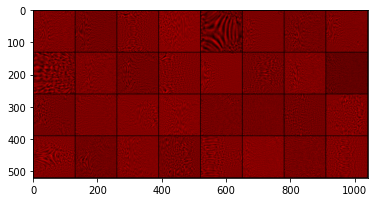

In [16]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.colorbar()
    plt.show()
    
imshow(torchvision.utils.make_grid(images))

In [17]:
# Call the CNN model and start training
model = Net(dropout = 0.3, linear_shape = par.dict['architecture']['linear_shape'][0]).to(device)
model.load_pretrained()
model.lock_base()
criterion = nn.MSELoss(reduction = 'mean')

Loading weights and bias from VGG16.


In [18]:
def check_accuracy(loader, model):
    if loader == train_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on validation data")

    sum_MSE = 0
    counter = 0
    loss = nn.MSELoss(reduction = 'mean')
    model.eval()
    
    # define two lists to save truth and predictions, for the plot only.
    y_list = torch.empty(0).to(device = device)
    pred_list = torch.empty(0).to(device = device)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            pred = torch.squeeze(model(x))
            pred_list = torch.cat((pred_list, pred), 0)
            y_list = torch.cat((y_list, y), 0)
            sum_MSE += loss(pred, y) * y.shape[0]
            counter += y.shape[0]
    
    fig, ax = plt.subplots(1,1, figsize = (5,5))
    img = ax.scatter(y_list.cpu().numpy(), pred_list.cpu().numpy(), s = 1)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100),'--', c = 'red')
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('Truth',fontsize = 16)
    ax.set_ylabel('Prediction', fontsize = 16)
    plt.show()
    
    model.train()
#     print( f"Got accuracy {float(sum_MSE)/float(counter):.6f}" )   
    return f"{float(sum_MSE)/float(counter):.6f}"
    
#     model.train()

In [19]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience = 5, min_delta = 0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [20]:
def train():
    early_stopping = EarlyStopping(patience = par.dict['patience'], min_delta = par.dict['min_delta'])
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total = len(train_loader), leave = True)
        
        if epoch % 2 == 0:
            val_acc = check_accuracy(validation_loader, model)
            loop.set_postfix(val_acc = val_acc)
            early_stopping(float(val_acc))
            if early_stopping.early_stop:
                par.add_training_process(acc_loss / counter , float(val_acc), epoch)
                break
                
        acc_loss = 0
        counter = 0
        
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = torch.squeeze(model(imgs))
            loss = criterion(outputs, labels)
            acc_loss += loss * labels.shape[0]
            counter += labels.shape[0]
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss = loss.item())
        
        par.add_training_process(acc_loss / counter , val_acc, epoch)
        print(f"Training acc: {float(acc_loss) / float(counter):.6f}, Validation accuracy {float(val_acc):.6f}")

  0%|                                                                                                                                                                                      | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


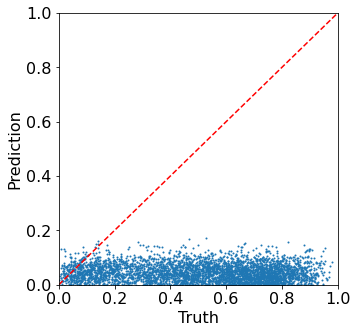

Epoch [0/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:41<00:00, 15.10it/s, loss=0.0152]


Training acc: 0.020316, Validation accuracy 0.278193


Epoch [1/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:33<00:00, 18.68it/s, loss=0.0227]


Training acc: 0.014816, Validation accuracy 0.278193


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


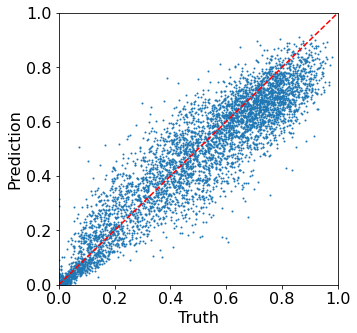

Epoch [2/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:42<00:00, 14.74it/s, loss=0.0185]


Training acc: 0.013727, Validation accuracy 0.010923


Epoch [3/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:35<00:00, 17.67it/s, loss=0.00871]


Training acc: 0.013062, Validation accuracy 0.010923


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


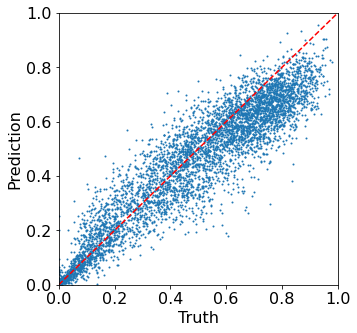

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.011090]

INFO: Early stopping counter 1 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [4/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:45<00:00, 13.78it/s, loss=0.00679]


Training acc: 0.012593, Validation accuracy 0.011090


Epoch [5/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:37<00:00, 16.87it/s, loss=0.00633]


Training acc: 0.011967, Validation accuracy 0.011090


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


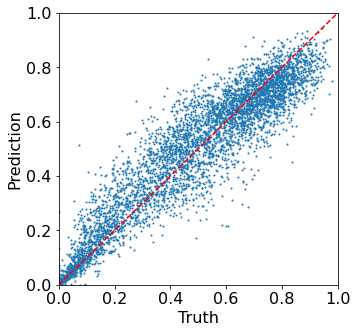

Epoch [6/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:46<00:00, 13.45it/s, loss=0.0104]


Training acc: 0.011886, Validation accuracy 0.008928


Epoch [7/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:36<00:00, 17.02it/s, loss=0.0064]


Training acc: 0.011445, Validation accuracy 0.008928


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


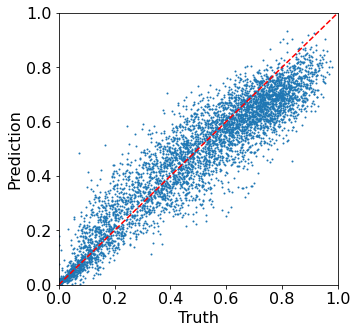

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.009495]

INFO: Early stopping counter 2 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [8/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:45<00:00, 13.85it/s, loss=0.0177]


Training acc: 0.011155, Validation accuracy 0.009495


Epoch [9/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:35<00:00, 17.59it/s, loss=0.00758]


Training acc: 0.011042, Validation accuracy 0.009495


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


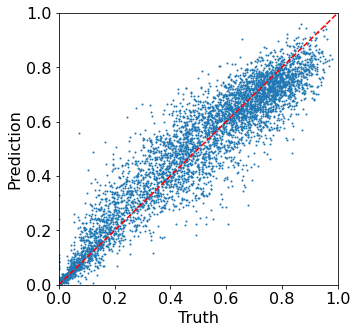

Epoch [10/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.28it/s, loss=0.00313]


Training acc: 0.010830, Validation accuracy 0.008369


Epoch [11/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:35<00:00, 17.81it/s, loss=0.0104]


Training acc: 0.010613, Validation accuracy 0.008369


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


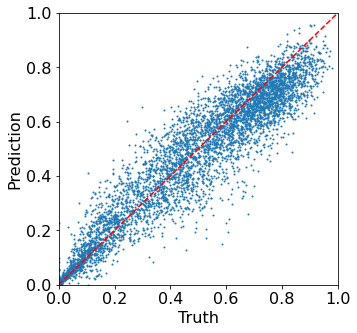

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.008626]

INFO: Early stopping counter 3 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [12/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.40it/s, loss=0.00922]


Training acc: 0.010412, Validation accuracy 0.008626


Epoch [13/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 17.97it/s, loss=0.013]


Training acc: 0.010336, Validation accuracy 0.008626


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


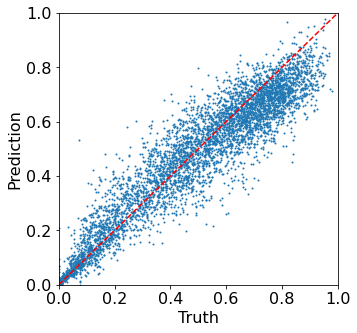

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.008701]

INFO: Early stopping counter 4 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [14/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.45it/s, loss=0.0128]


Training acc: 0.009960, Validation accuracy 0.008701


Epoch [15/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 17.91it/s, loss=0.00966]


Training acc: 0.009939, Validation accuracy 0.008701


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


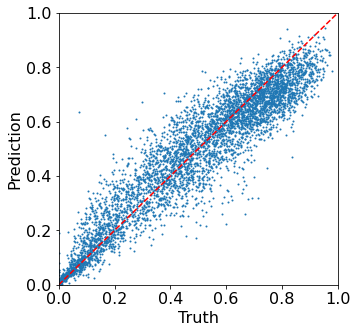

Epoch [16/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.48it/s, loss=0.00805]


Training acc: 0.009693, Validation accuracy 0.008173


Epoch [17/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 17.89it/s, loss=0.00426]


Training acc: 0.009788, Validation accuracy 0.008173


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


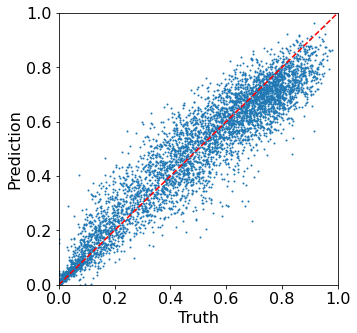

Epoch [18/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.51it/s, loss=0.00902]


Training acc: 0.009733, Validation accuracy 0.008035


Epoch [19/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:35<00:00, 17.87it/s, loss=0.0104]


Training acc: 0.009448, Validation accuracy 0.008035


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


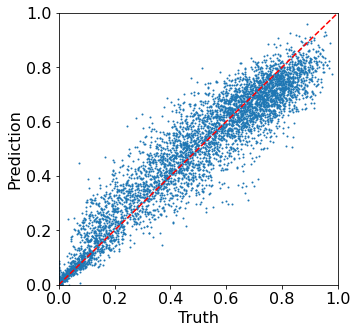

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007939]

INFO: Early stopping counter 5 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [20/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.44it/s, loss=0.00739]


Training acc: 0.009311, Validation accuracy 0.007939


Epoch [21/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 17.90it/s, loss=0.00229]


Training acc: 0.009265, Validation accuracy 0.007939


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


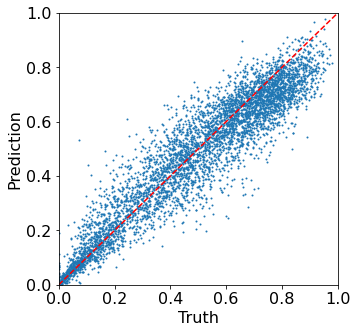

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.008049]

INFO: Early stopping counter 6 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [22/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.49it/s, loss=0.00289]


Training acc: 0.008956, Validation accuracy 0.008049


Epoch [23/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 17.95it/s, loss=0.00331]


Training acc: 0.009019, Validation accuracy 0.008049


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


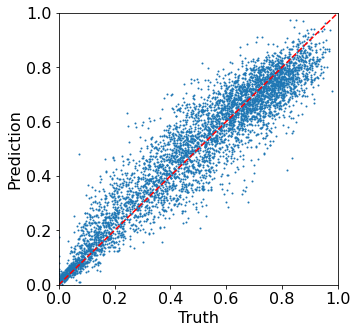

Epoch [24/100]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.49it/s, loss=0.013]


Training acc: 0.008989, Validation accuracy 0.007694


Epoch [25/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:35<00:00, 17.89it/s, loss=0.00608]


Training acc: 0.008760, Validation accuracy 0.007694


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


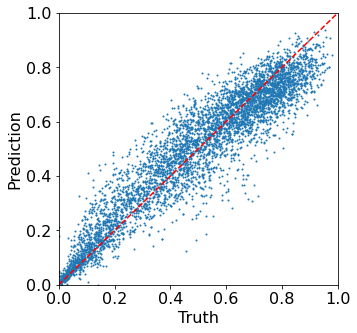

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007662]

INFO: Early stopping counter 7 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [26/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.46it/s, loss=0.0105]


Training acc: 0.008767, Validation accuracy 0.007662


Epoch [27/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 18.02it/s, loss=0.0028]


Training acc: 0.008735, Validation accuracy 0.007662


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


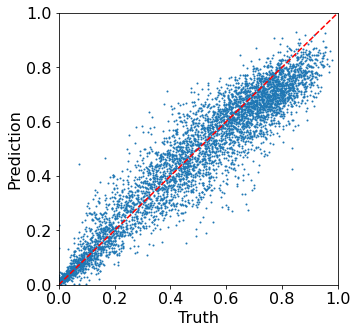

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007911]

INFO: Early stopping counter 8 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [28/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.38it/s, loss=0.00312]


Training acc: 0.008610, Validation accuracy 0.007911


Epoch [29/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 17.91it/s, loss=0.00813]


Training acc: 0.008575, Validation accuracy 0.007911


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


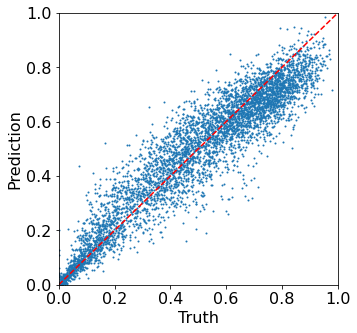

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007715]

INFO: Early stopping counter 9 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [30/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.51it/s, loss=0.00378]


Training acc: 0.008463, Validation accuracy 0.007715


Epoch [31/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 17.98it/s, loss=0.00619]


Training acc: 0.008377, Validation accuracy 0.007715


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


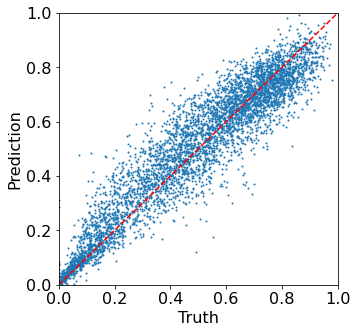

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007603]

INFO: Early stopping counter 10 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [32/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.36it/s, loss=0.00972]


Training acc: 0.008440, Validation accuracy 0.007603


Epoch [33/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:35<00:00, 17.88it/s, loss=0.00821]


Training acc: 0.008341, Validation accuracy 0.007603


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


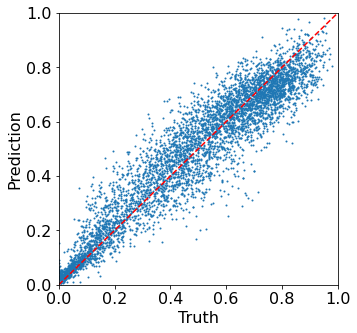

Epoch [34/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.43it/s, loss=0.00812]


Training acc: 0.008279, Validation accuracy 0.007445


Epoch [35/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 17.95it/s, loss=0.00832]


Training acc: 0.008249, Validation accuracy 0.007445


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


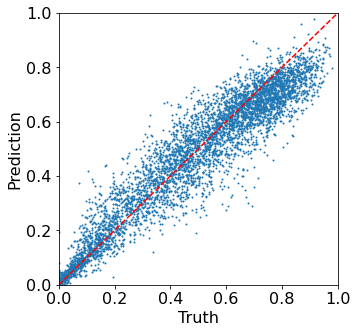

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007472]

INFO: Early stopping counter 11 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [36/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:43<00:00, 14.53it/s, loss=0.00279]


Training acc: 0.008181, Validation accuracy 0.007472


Epoch [37/100]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:35<00:00, 17.82it/s, loss=0.01]


Training acc: 0.008114, Validation accuracy 0.007472


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


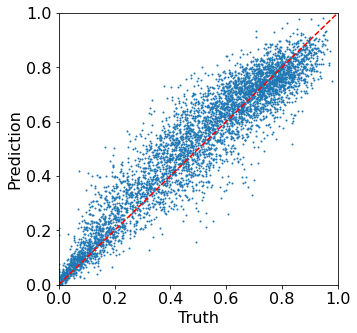

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007875]

INFO: Early stopping counter 12 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [38/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:42<00:00, 14.57it/s, loss=0.00367]


Training acc: 0.008141, Validation accuracy 0.007875


Epoch [39/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 17.91it/s, loss=0.00418]


Training acc: 0.008035, Validation accuracy 0.007875


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


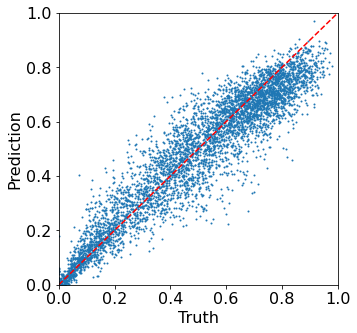

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007623]

INFO: Early stopping counter 13 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [40/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:42<00:00, 14.60it/s, loss=0.0067]


Training acc: 0.007919, Validation accuracy 0.007623


Epoch [41/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 18.21it/s, loss=0.00318]


Training acc: 0.007860, Validation accuracy 0.007623


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


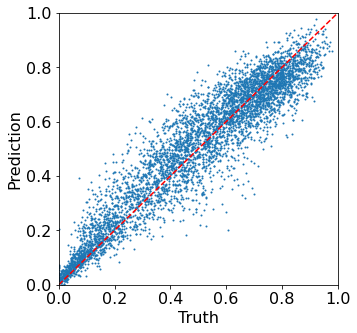

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007456]

INFO: Early stopping counter 14 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [42/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:42<00:00, 14.69it/s, loss=0.00852]


Training acc: 0.007839, Validation accuracy 0.007456


Epoch [43/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 18.15it/s, loss=0.0119]


Training acc: 0.007800, Validation accuracy 0.007456


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


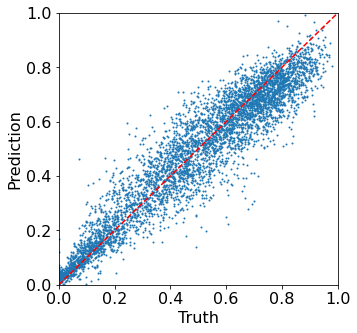

Epoch [44/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:42<00:00, 14.69it/s, loss=0.00664]


Training acc: 0.007726, Validation accuracy 0.007165


Epoch [45/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 18.14it/s, loss=0.00218]


Training acc: 0.007803, Validation accuracy 0.007165


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


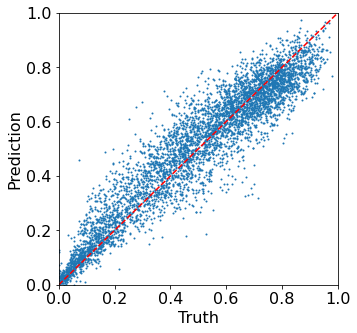

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007197]

INFO: Early stopping counter 15 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [46/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:42<00:00, 14.68it/s, loss=0.00852]


Training acc: 0.007649, Validation accuracy 0.007197


Epoch [47/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 18.22it/s, loss=0.00443]


Training acc: 0.007737, Validation accuracy 0.007197


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


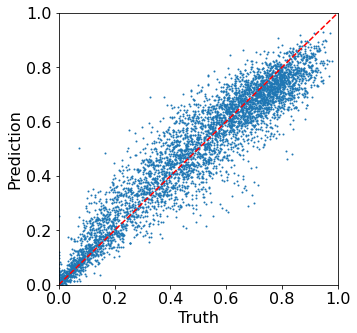

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007274]

INFO: Early stopping counter 16 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [48/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:42<00:00, 14.71it/s, loss=0.00643]


Training acc: 0.007561, Validation accuracy 0.007274


Epoch [49/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 18.24it/s, loss=0.00654]


Training acc: 0.007478, Validation accuracy 0.007274


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


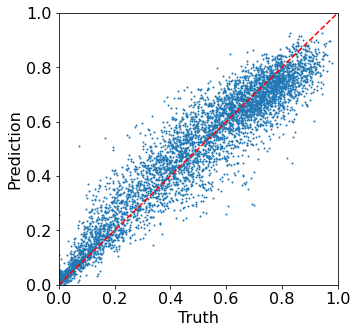

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007353]

INFO: Early stopping counter 17 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [50/100]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:42<00:00, 14.64it/s, loss=0.0161]


Training acc: 0.007623, Validation accuracy 0.007353


Epoch [51/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 18.25it/s, loss=0.00602]


Training acc: 0.007554, Validation accuracy 0.007353


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


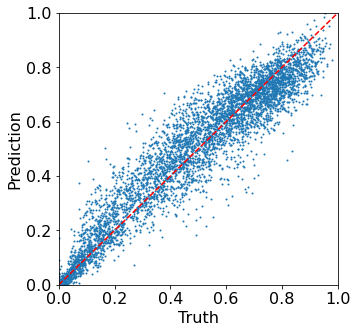

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007261]

INFO: Early stopping counter 18 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [52/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:42<00:00, 14.72it/s, loss=0.00531]


Training acc: 0.007567, Validation accuracy 0.007261


Epoch [53/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 18.25it/s, loss=0.00973]


Training acc: 0.007360, Validation accuracy 0.007261


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


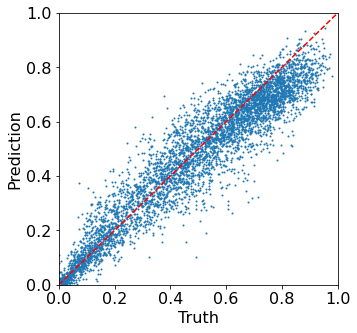

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007435]

INFO: Early stopping counter 19 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [54/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:42<00:00, 14.59it/s, loss=0.00653]


Training acc: 0.007400, Validation accuracy 0.007435


Epoch [55/100]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:34<00:00, 18.15it/s, loss=0.00537]


Training acc: 0.007348, Validation accuracy 0.007435


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


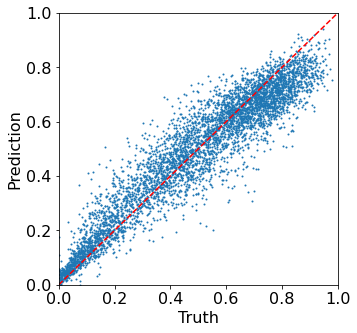

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.007380]

INFO: Early stopping counter 20 of 20
INFO: Early stopping


In [21]:
stage = 0
learning_rate = par.dict['optimizer']['lr'][stage]
num_epochs = par.dict['epoch'][stage]
betas = par.dict['optimizer']['beta'][stage]
eps = par.dict['optimizer']['eps'][stage]
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, eps = eps)
train()

  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


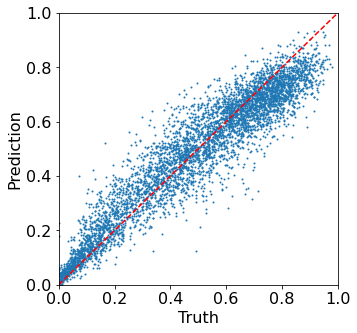

Epoch [0/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.61it/s, loss=0.012]


Training acc: 0.006497, Validation accuracy 0.007424


Epoch [1/50]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.91it/s, loss=0.0013]


Training acc: 0.005456, Validation accuracy 0.007424


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


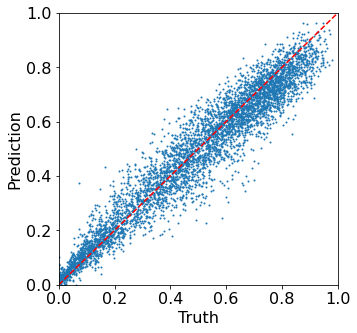

Epoch [2/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.61it/s, loss=0.00513]


Training acc: 0.004825, Validation accuracy 0.004934


Epoch [3/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.91it/s, loss=0.00289]


Training acc: 0.004534, Validation accuracy 0.004934


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


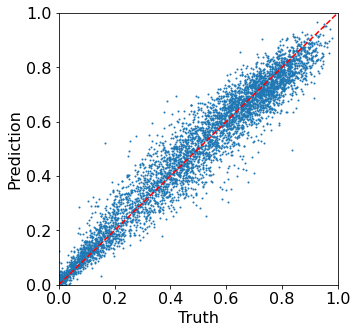

Epoch [4/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.62it/s, loss=0.00306]


Training acc: 0.004171, Validation accuracy 0.004276


Epoch [5/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.92it/s, loss=0.00424]


Training acc: 0.003985, Validation accuracy 0.004276


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


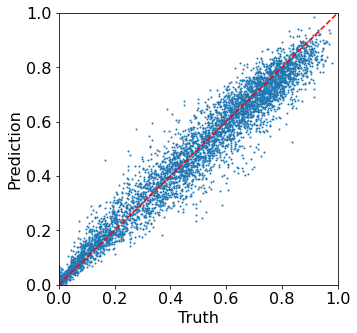

Epoch [6/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.62it/s, loss=0.00339]


Training acc: 0.003786, Validation accuracy 0.003911


Epoch [7/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.91it/s, loss=0.00198]


Training acc: 0.003676, Validation accuracy 0.003911


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


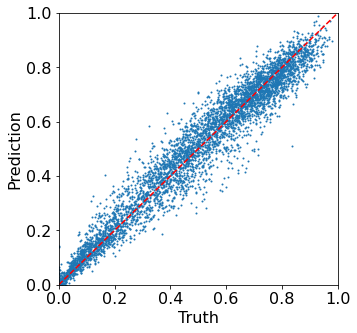

Epoch [8/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.61it/s, loss=0.000931]


Training acc: 0.003467, Validation accuracy 0.003521


Epoch [9/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.91it/s, loss=0.00541]


Training acc: 0.003347, Validation accuracy 0.003521


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


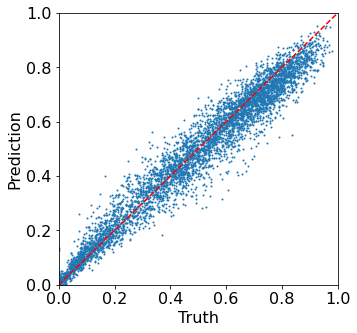

Epoch [10/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.61it/s, loss=0.00204]


Training acc: 0.003179, Validation accuracy 0.003411


Epoch [11/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.91it/s, loss=0.00355]


Training acc: 0.003141, Validation accuracy 0.003411


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


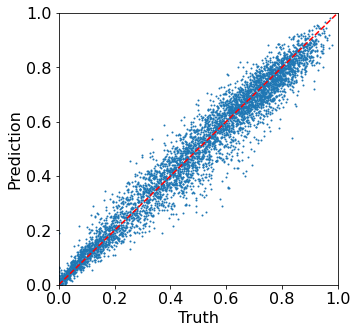

Epoch [12/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.61it/s, loss=0.0045]


Training acc: 0.003007, Validation accuracy 0.003174


Epoch [13/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.91it/s, loss=0.000796]


Training acc: 0.002891, Validation accuracy 0.003174


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


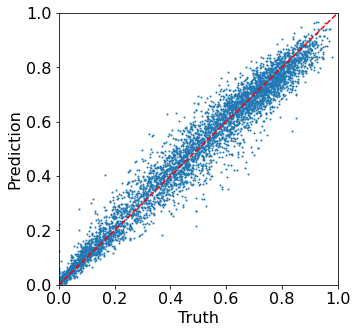

Epoch [14/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.60it/s, loss=0.00585]


Training acc: 0.002772, Validation accuracy 0.003033


Epoch [15/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.90it/s, loss=0.00144]


Training acc: 0.002727, Validation accuracy 0.003033


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


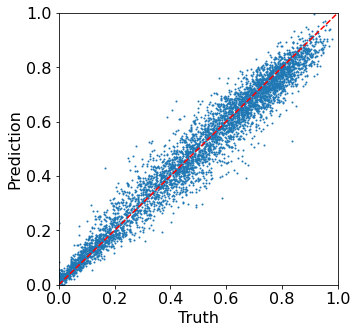

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002980]

INFO: Early stopping counter 1 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [16/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.60it/s, loss=0.00297]


Training acc: 0.002710, Validation accuracy 0.002980


Epoch [17/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.91it/s, loss=0.00156]


Training acc: 0.002557, Validation accuracy 0.002980


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


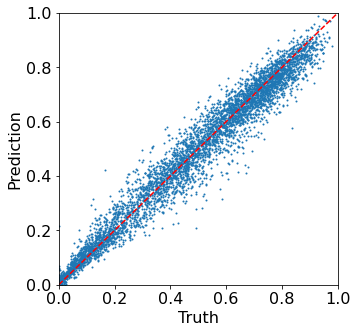

Epoch [18/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.59it/s, loss=0.00337]


Training acc: 0.002538, Validation accuracy 0.002768


Epoch [19/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.88it/s, loss=0.00147]


Training acc: 0.002489, Validation accuracy 0.002768


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


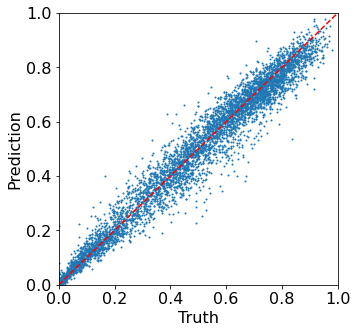

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002780]

INFO: Early stopping counter 2 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [20/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.58it/s, loss=0.000679]


Training acc: 0.002399, Validation accuracy 0.002780


Epoch [21/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.88it/s, loss=0.00435]


Training acc: 0.002345, Validation accuracy 0.002780


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


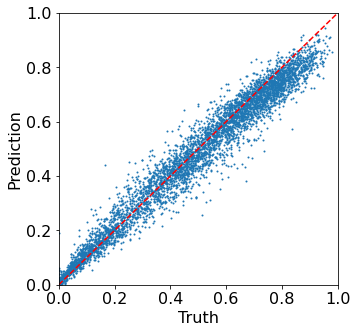

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.003008]

INFO: Early stopping counter 3 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [22/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.57it/s, loss=0.00146]


Training acc: 0.002335, Validation accuracy 0.003008


Epoch [23/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.88it/s, loss=0.00227]


Training acc: 0.002206, Validation accuracy 0.003008


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


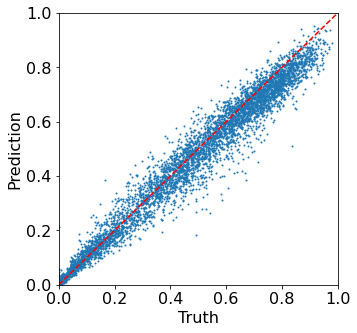

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.003082]

INFO: Early stopping counter 4 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [24/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.59it/s, loss=0.00186]


Training acc: 0.002227, Validation accuracy 0.003082


Epoch [25/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.88it/s, loss=0.00362]


Training acc: 0.002149, Validation accuracy 0.003082


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


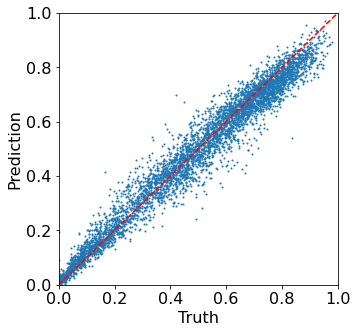

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002758]

INFO: Early stopping counter 5 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [26/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.58it/s, loss=0.0021]


Training acc: 0.002121, Validation accuracy 0.002758


Epoch [27/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.89it/s, loss=0.00421]


Training acc: 0.002082, Validation accuracy 0.002758


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


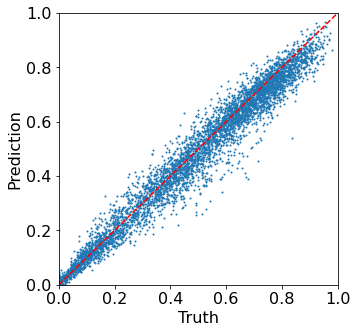

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002687]

INFO: Early stopping counter 6 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [28/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.61it/s, loss=0.00173]


Training acc: 0.002031, Validation accuracy 0.002687


Epoch [29/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.90it/s, loss=0.000905]


Training acc: 0.001985, Validation accuracy 0.002687


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


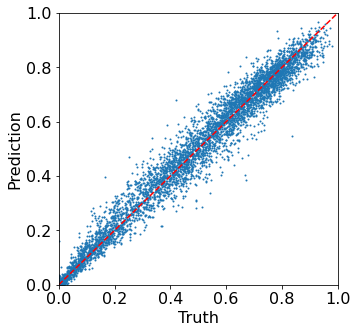

Epoch [30/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.59it/s, loss=0.00327]


Training acc: 0.001945, Validation accuracy 0.002435


Epoch [31/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:08<00:00,  4.88it/s, loss=0.000542]


Training acc: 0.001985, Validation accuracy 0.002435


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


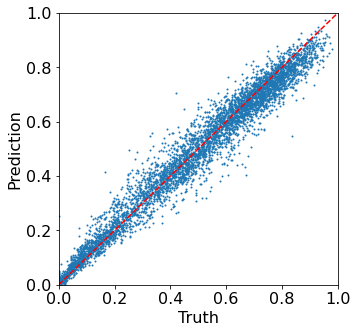

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002602]

INFO: Early stopping counter 7 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [32/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:16<00:00,  4.59it/s, loss=0.00121]


Training acc: 0.001873, Validation accuracy 0.002602


Epoch [33/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.90it/s, loss=0.000488]


Training acc: 0.001874, Validation accuracy 0.002602


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


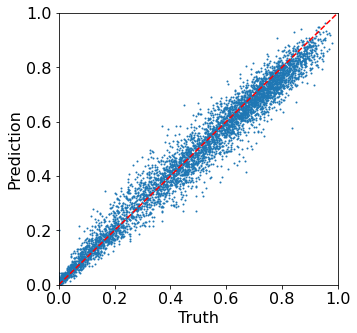

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002463]

INFO: Early stopping counter 8 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [34/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.61it/s, loss=0.00288]


Training acc: 0.001821, Validation accuracy 0.002463


Epoch [35/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.92it/s, loss=0.000885]


Training acc: 0.001849, Validation accuracy 0.002463


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


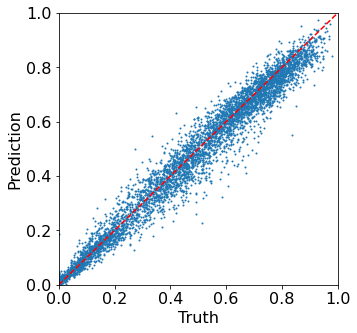

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002423]

INFO: Early stopping counter 9 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [36/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.62it/s, loss=0.000559]


Training acc: 0.001765, Validation accuracy 0.002423


Epoch [37/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.92it/s, loss=0.00373]


Training acc: 0.001735, Validation accuracy 0.002423


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


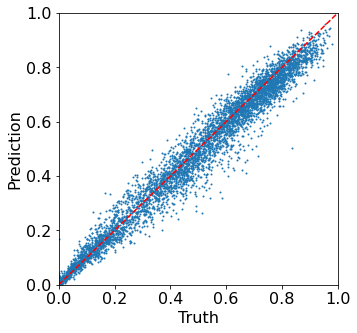

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002434]

INFO: Early stopping counter 10 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [38/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.61it/s, loss=0.00192]


Training acc: 0.001707, Validation accuracy 0.002434


Epoch [39/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.92it/s, loss=0.000937]


Training acc: 0.001730, Validation accuracy 0.002434


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


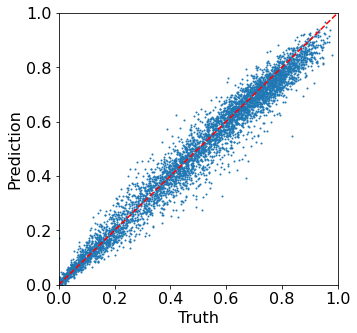

Epoch [40/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.62it/s, loss=0.00154]


Training acc: 0.001676, Validation accuracy 0.002304


Epoch [41/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.92it/s, loss=0.000531]


Training acc: 0.001660, Validation accuracy 0.002304


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


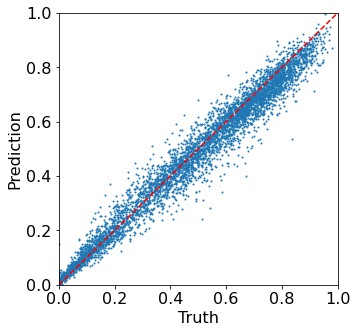

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002458]

INFO: Early stopping counter 11 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [42/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.62it/s, loss=0.00372]


Training acc: 0.001639, Validation accuracy 0.002458


Epoch [43/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.92it/s, loss=0.00104]


Training acc: 0.001609, Validation accuracy 0.002458


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


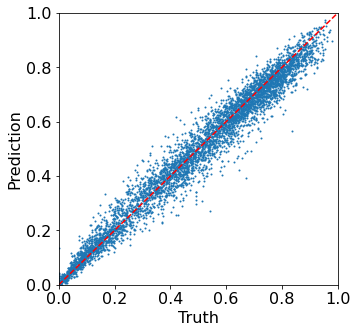

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002210]

INFO: Early stopping counter 12 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [44/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.62it/s, loss=0.00163]


Training acc: 0.001588, Validation accuracy 0.002210


Epoch [45/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.92it/s, loss=0.00155]


Training acc: 0.001597, Validation accuracy 0.002210


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


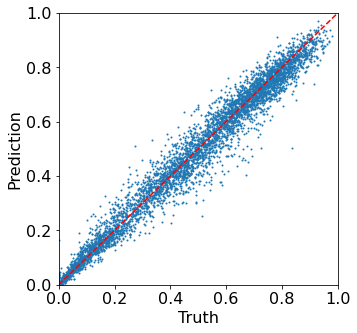

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002239]

INFO: Early stopping counter 13 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [46/50]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.62it/s, loss=0.00103]


Training acc: 0.001537, Validation accuracy 0.002239


Epoch [47/50]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.92it/s, loss=0.0018]


Training acc: 0.001517, Validation accuracy 0.002239


  0%|                                                                                                                                                                              | 0/626 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


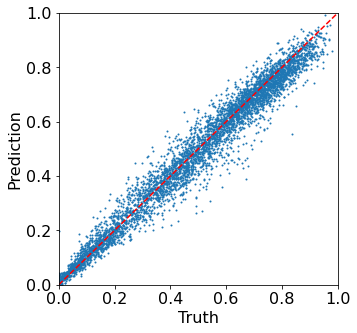

  0%|                                                                                                                                                            | 0/626 [00:08<?, ?it/s, val_acc=0.002271]

INFO: Early stopping counter 14 of 20


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [48/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:15<00:00,  4.61it/s, loss=0.000462]


Training acc: 0.001512, Validation accuracy 0.002271


Epoch [49/50]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [02:07<00:00,  4.91it/s, loss=0.000895]

Training acc: 0.001488, Validation accuracy 0.002271


In [22]:
stage = 1
learning_rate = par.dict['optimizer']['lr'][stage]
num_epochs = par.dict['epoch'][stage]
betas = par.dict['optimizer']['beta'][stage]
eps = par.dict['optimizer']['eps'][stage]
model.unlock_base()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, eps = eps)
train()

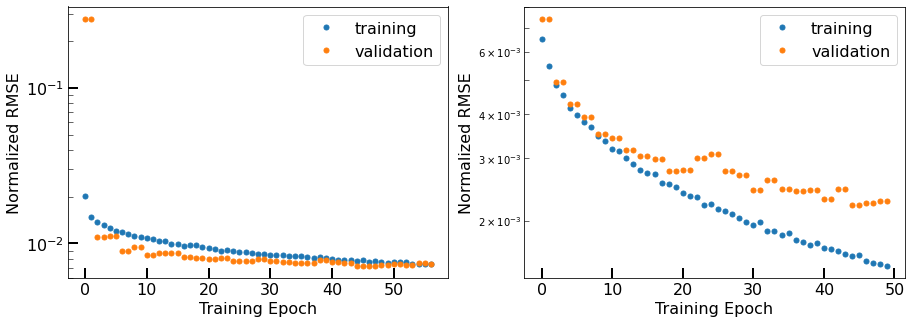

In [23]:
fig = plt.figure(figsize=[15,5])

ax = fig.add_subplot(121)
ax.plot(np.array(par.process['training'][0]), '.', markersize = 10 , label = 'training')
ax.plot(np.array(par.process['validation'][0], dtype = 'float'), '.', markersize = 10 , label = 'validation')
ax.set_yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(which='major',direction = 'in', length = 10, width = 2)
plt.tick_params(which='minor',direction = 'in', length = 5)
ax.set_xlabel('Training Epoch',fontsize = 16)
ax.set_ylabel('Normalized RMSE', fontsize = 16)
plt.legend(fontsize = 16)

ax = fig.add_subplot(122)
ax.plot(np.array(par.process['training'][1]), '.', markersize = 10 , label = 'training')
ax.plot(np.array(par.process['validation'][1], dtype = 'float'), '.', markersize = 10 , label = 'validation')
ax.set_yscale('log')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(which='major',direction = 'in', length = 10, width = 2)
plt.tick_params(which='minor',direction = 'in', length = 5)
ax.set_xlabel('Training Epoch',fontsize = 16)
ax.set_ylabel('Normalized RMSE', fontsize = 16)
plt.legend(fontsize = 16)

In [24]:
torch.save(model.state_dict(), 'TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt06_.pt')
par.save_result('TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt06_')

In [25]:
file = open("TorchModels/Test18_Nion_2ndorder_45mradApt_50mradLimit_emit+defocus_Adam_attempt06_training_log.pkl",'rb')
object_file = pickle.load(file)
file.close()

In [26]:
print(object_file['training'][0][-1])
print(object_file['validation'][0][-1])
print(object_file['training'][1][-1])
print(object_file['validation'][1][-1])

0.0073477505
0.00738
0.0014884579
0.002271
